# Test finding conserved quantities in Neumann model - traj2circle

In [1]:
import numpy as np
import tensorflow as tf
import sys
sys.path.append("../")
import os
import matplotlib.pyplot as plt
from IPython import display

from models import *
from hamiltonians import parameterized_neumann
from utils import make_train_op
from losses import make_circle_loss
from data import make_data
from utils import visualize_chain_bijector, is_symplectic
from utils import plot_traj, pull_back_traj

DTYPE=tf.float32
NP_DTYPE=np.float32


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
tf.set_random_seed(0)

In [3]:
sess = tf.InteractiveSession()

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Settings

In [15]:
frequencies = [.1, .2, .3]
settings = {
    'frequencies': frequencies,
    'hamiltonian': parameterized_neumann(frequencies),
    'd': 3,                    # space dimension
    'num_particles': 1,        # number of particles
    'minibatch_size': 2**7,    # Mini batch size
    'num_time_samples': 2**12, 
    'num_stacks_bijectors': 4, # Number of bijectors
    'log_dir' : "/tmp/log/im_tests/neumann-traj-3/",
    'ckpt_freq': 1000,
    'train_iters': 2,
    'visualize': True,
#    'grad_clip_norm': 1e-10, # clip norm to val. Comment for no gradient clipping
    'starter_learning_rate': 0.00001,    
    'decay_lr': "piecewise",
    'boundaries': [20000, 50000, 100000], # for piecewise decay
    'values': [1e-3, 1e-4, 1e-5, 1e-6],  # for piecewise decay
    'min_learning_rate': 1e-6   
    }

## Trajectories

In [16]:
# Use HamiltonianFlow as integrator of Hamiltonian
integrator = HamiltonianFlow(settings['hamiltonian'],
                             initial_t=0., 
                             final_t=10., 
                             num_steps=settings['num_time_samples'])

In [17]:
def make_uniform_coords_sphere(d, radius=[1.,2.]):
    """Evenly divide each coordinate. Set momenta to arbitrary."""
    num_init = len(radius)
    radius = np.reshape( np.array(radius), (num_init,1) )
    qsq = np.tile(radius**2 / d, d) # num_init x d
    qs = np.sqrt( qsq )
    ps = np.tile(np.arange(1,d+1)*0.1, (num_init,1))
    xs = np.stack([qs, ps], axis=2)
    return xs

In [18]:
num_init_cond = 3
#x0 = [1,.1,2,.2,3,.3, 2.1,.5,2.9,.6,3.5,.7]
x0 = make_uniform_coords_sphere(settings['d'], radius=[3.,5.,7.])
x0 = np.reshape(x0, (num_init_cond, settings['d'], settings['num_particles'], 2)).astype(NP_DTYPE)
q0,p0 = extract_q_p(x0)
print("q0 = ", np.reshape(q0,[-1]))
print("p0 = ", np.reshape(p0,[-1]))
print("E  = ", sess.run( settings['hamiltonian'](tf.constant(x0)) ))

q0 =  [1.7320508 1.7320508 1.7320508 2.8867514 2.8867514 2.8867514 4.041452
 4.041452  4.041452 ]
p0 =  [0.1 0.2 0.3 0.1 0.2 0.3 0.1 0.2 0.3]
E  =  [0.99      2.7500002 5.3900003]


In [19]:
traj = sess.run( integrator(x0, return_full_state=True) )
# traj has shape (num_time_samples,batch,d,n,2). Reinterpret batch and num_time_samples as batch
print(traj.shape)
qtraj, ptraj = extract_q_p( traj )

(4096, 3, 3, 1, 2)


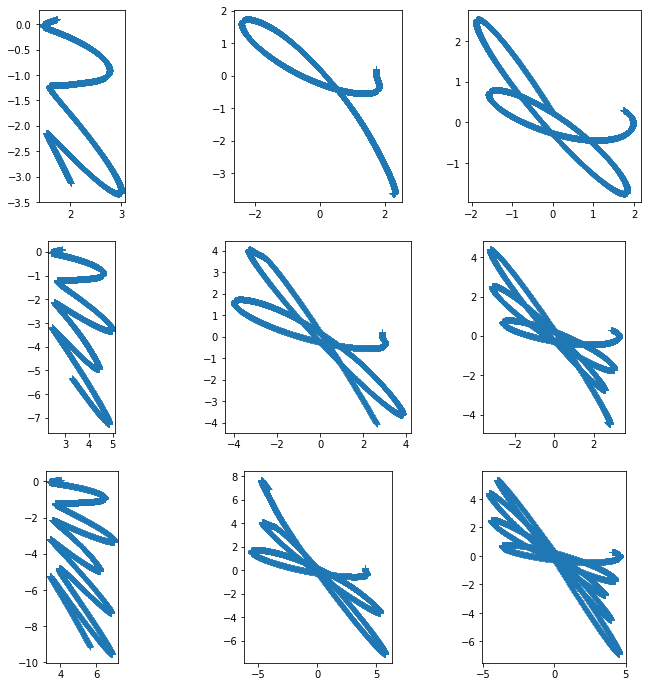

In [20]:
# orbits
plot_traj(settings, qtraj, ptraj)

Constants of motion:
$$
I_\alpha = x_\alpha^2 + \sum_{\beta\neq \alpha} \frac{J_{\alpha\beta}^2}{k_\alpha-k_\beta}
$$

In [21]:
def Is(traj):
    xs, ps = extract_q_p(traj)
    ks = settings['frequencies']
    Is = xs**2
    Is = Is[:,:,:,0,0]
    for a in range( settings['d'] ):
        for b in range( settings['d'] ):
            if b != a:
                J = xs[:,:,a,0,0]*ps[:,:,b,0,0] - ps[:,:,a,0,0]*xs[:,:,b,0,0]
                Is[:,:,a] += J**2 / (ks[a] - ks[b])
    return Is

In [22]:
I_traj = Is(traj)
print(I_traj.shape)

(4096, 3, 3)


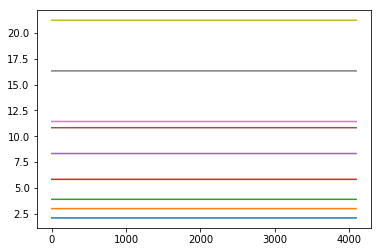

In [23]:
for b in range(I_traj.shape[1]):
    for a in range(I_traj.shape[2]):
        plt.plot(I_traj[:,b,a])

## Define the model and loss

Define the model T as sequence of symplectic transformations 

In [24]:
# No oscillator flow, map directly to phat,qhat cartesian coords of action-angle
stack = []
for i in range(settings['num_stacks_bijectors']):
    stack.extend([ZeroCenter(),
                  LinearSymplectic(householder_random_init=False),
#                  SymplecticAdditiveCoupling(shift_model=MLP(activation=tf.nn.tanh))])
                  SymplecticAdditiveCoupling(shift_model=IrrotationalMLP())])
T = Chain(stack)

Data, loss and train op:

In [25]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)

# traj is (num_time_samples,batch,d,n,2)
dataset = tf.data.Dataset.from_tensor_slices(traj.astype(NP_DTYPE))
# repeat the dataset indefinetely
dataset = dataset.repeat()
# Shuffle data every epoch time (0th) dimension
dataset = dataset.shuffle(settings['num_time_samples'])
# Specify the minibatch size
dataset = dataset.batch(settings['minibatch_size'])
data_iterator = dataset.make_one_shot_iterator()
x = data_iterator.get_next()

#loss = make_loss(settings, T, x)
with tf.name_scope("canonical_transformation"):
    z = pull_back_traj(settings, T, x)
    loss = make_circle_loss(z) 

train_op = make_train_op(settings, loss, step)

## Train

In [26]:
sess.run(tf.global_variables_initializer())

In [44]:
# Set the ZeroCenter bijectors to prediction mode:
for i, bijector in enumerate(T.bijectors):    
    if hasattr(bijector, 'is_training'):
        T.bijectors[i].is_training = True

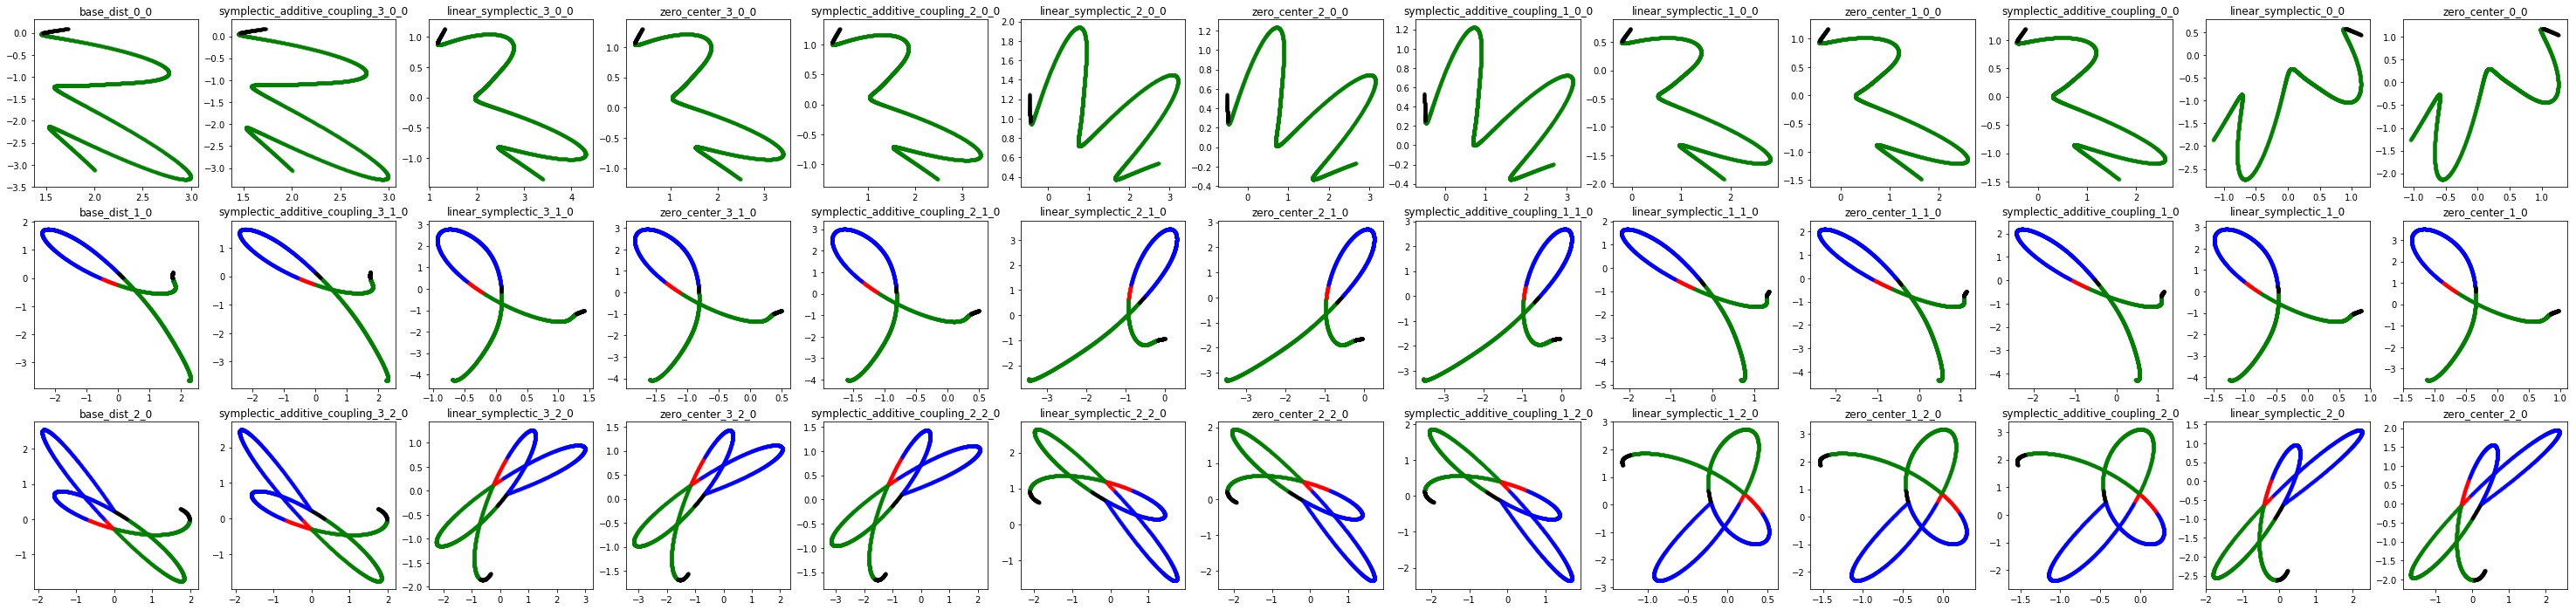

In [27]:
traj_to_show = tf.constant(traj[:,0,:,:,:], dtype=DTYPE)
visualize_chain_bijector(T, traj_to_show, sess=sess, inverse=True)

In [28]:
losses = []
# Coordinates to monitor
dd = 0; nn = 0
loss_np = 1 # Init
loss_converged = 5e-7

In [29]:
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter(settings['log_dir'], sess.graph)
checkpoint_dir = settings['log_dir']
checkpoint_prefix = checkpoint_dir + "model.ckpt"
saver = tf.train.Saver(max_to_keep=2)

Loss at 236000 is 0.2956204414367676


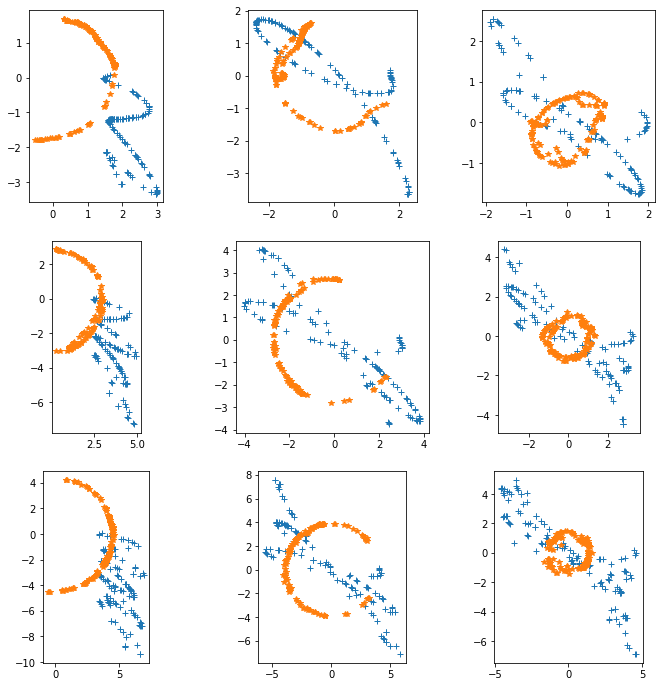

KeyboardInterrupt: 

In [45]:
while loss_np > loss_converged:
    _, summary, it, loss_np = sess.run([train_op, merged, step, loss])
    writer.add_summary(summary, it)
    
#     if it % settings['ckpt_freq'] == 0:
#         saver.save(sess, checkpoint_prefix, global_step=it) #, write_meta_graph=True)
    
    _, it, loss_np = sess.run([train_op, step, loss])
    if it % 1000 == 0:        
        display.clear_output(wait=True)
        print("Loss at {} is {}".format(it, loss_np))
        
        qtraj_mini,ptraj_mini = sess.run(extract_q_p(x))
        qhat_traj_mini,phat_traj_mini = sess.run(extract_q_p(z))

        plot_traj(settings, qtraj_mini, ptraj_mini, qhat_traj_mini, phat_traj_mini)
        #plt.savefig('../results/kepler/image_at_it_{:04d}.png'.format(it))
        plt.show()   
    losses.append(loss_np)

In [31]:
# n = 2
# plt.plot(qtraj[:,n,0,0], ptraj[:,n,0,0], '-')
# plt.plot(qhat_traj[:,n,0,0], phat_traj[:,n,0,0], '*')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.savefig('../results/neumann_t2c.png')

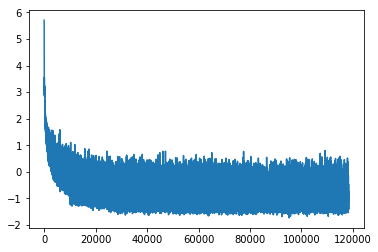

In [46]:
plt.plot(np.log(losses[:]))

In [47]:
saver.save(sess, checkpoint_prefix, global_step=it)

'/tmp/log/im_tests/neumann-traj-3/model.ckpt-236648'

## Test

In [20]:
saver = tf.train.Saver()
checkpoint_dir = settings['log_dir']
checkpoint_prefix = checkpoint_dir + "model.ckpt"
saver.restore(sess, checkpoint_prefix)

INFO:tensorflow:Restoring parameters from /tmp/log/im_tests/neumann-traj-2/model.ckpt


In [48]:
# Set the ZeroCenter bijectors to prediction mode:
for i, bijector in enumerate(T.bijectors):    
    if hasattr(bijector, 'is_training'):
        T.bijectors[i].is_training = False

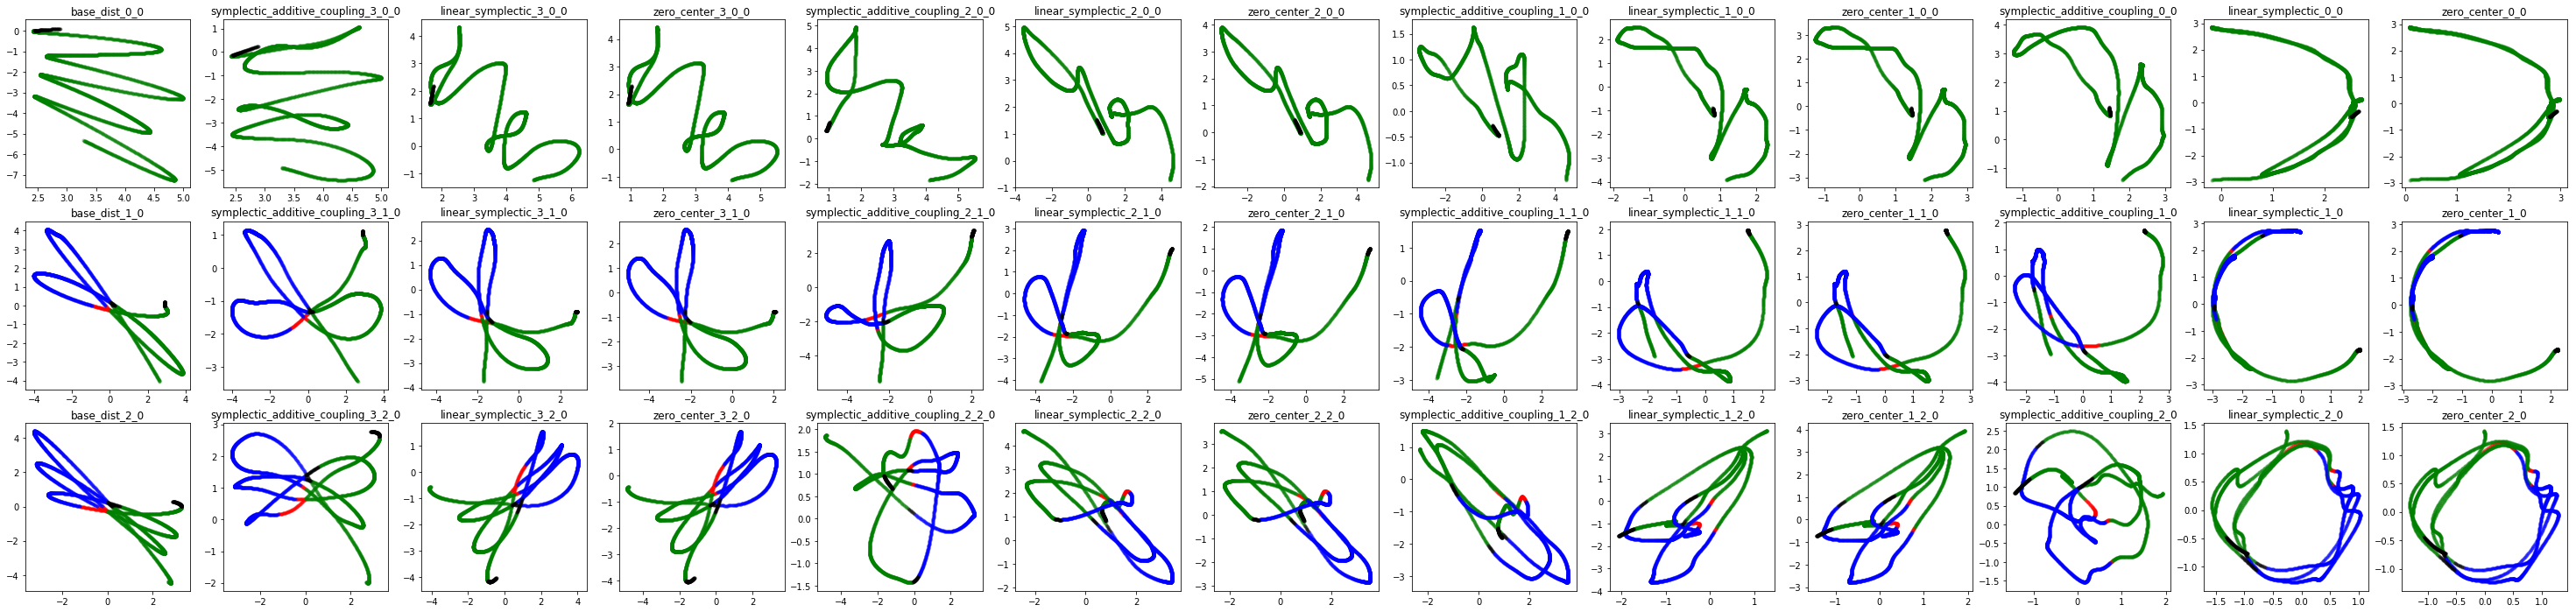

In [49]:
traj_to_show = tf.constant(traj[:,1,:,:,:], dtype=DTYPE)
visualize_chain_bijector(T, traj_to_show, sess=sess, inverse=True)

In [50]:
radius = [1.,2.,3.,4.,5.,6.,7.,8.,9.]
num_init_cond = len(radius)
#x0 = [1,.1,2,.2,3,.3, 2.1,.5,2.9,.6,3.5,.7]
x0_test = make_uniform_coords_sphere(settings['d'], radius=radius)
x0_test = np.reshape(x0_test, (num_init_cond, settings['d'], settings['num_particles'], 2)).astype(NP_DTYPE)
q0_test,p0_test = extract_q_p(x0_test)
print("q0 = ", np.reshape(q0_test,[-1]))
print("p0 = ", np.reshape(p0_test,[-1]))
print("E  = ", sess.run( settings['hamiltonian'](tf.constant(x0_test)) ))

q0 =  [0.57735026 0.57735026 0.57735026 1.1547005  1.1547005  1.1547005
 1.7320508  1.7320508  1.7320508  2.309401   2.309401   2.309401
 2.8867514  2.8867514  2.8867514  3.4641016  3.4641016  3.4641016
 4.041452   4.041452   4.041452   4.618802   4.618802   4.618802
 5.196152   5.196152   5.196152  ]
p0 =  [0.1 0.2 0.3 0.1 0.2 0.3 0.1 0.2 0.3 0.1 0.2 0.3 0.1 0.2 0.3 0.1 0.2 0.3
 0.1 0.2 0.3 0.1 0.2 0.3 0.1 0.2 0.3]
E  =  [0.10999999 0.43999997 0.99       1.7599999  2.7500002  3.96
 5.3900003  7.0399995  8.91      ]


In [51]:
traj_test = sess.run( integrator(x0_test, return_full_state=True) )
# traj has shape (num_time_samples,batch,d,n,2). Reinterpret batch and num_time_samples as batch
print(traj_test.shape)
qtraj_test, ptraj_test = extract_q_p( traj_test )

(4096, 9, 3, 1, 2)


In [52]:
# orbits
#plot_traj(settings, qtraj_test, ptraj_test)

In [53]:
for b in range(num_init_cond):
    tmp = tf.constant(traj_test[:,b,:,:,:], dtype=DTYPE)
    tmp = tf.expand_dims(tmp, axis=1)

    z_test = pull_back_traj(settings, T, tmp)
    loss_test = make_circle_loss(z_test) 

    #qtraj_test_tmp,ptraj_test_tmp = extract_q_p(tmp)    
    #qhat_traj_test,phat_traj_test = sess.run(extract_q_p(z_test))
    #plot_traj(settings, qtraj_test_tmp, ptraj_test_tmp, qhat_traj_test, phat_traj_test)
    print("Test error: ", sess.run(loss_test))

Test error:  0.00020849607
Test error:  6.4857086e-05
Test error:  3.7209862e-05
Test error:  0.00023187183
Test error:  0.00012420233
Test error:  0.0011747197
Test error:  0.0002336134
Test error:  0.01415657
Test error:  0.04142079


Trajectory generation: 

In [71]:
settings_test = settings
settings_test['base_dist'] = "action_dirac_angle"
settings_test['dataset_size'] = settings_test['num_time_samples']
settings_test['minibatch_size'] = settings_test['num_time_samples']
# Choose a batch of actions: needs to be divisor of dataset_size or minibatch_size if infinite dataset
r = np.random.RandomState(seed=0)
num_samples_actions = 1 # number of distinct actions (Liouville torii)
sh = (num_samples_actions, settings['d'], settings['num_particles'], 1)
settings_test['value_actions'] = 1 * r.rand(*sh).astype(NP_DTYPE)
print(settings_test['value_actions'])

# circles by mapping to symplectic radial to cartesian coords
circles = OscillatorFlow()( make_data(settings_test, sess) )

[[[[0.5488135 ]]

  [[0.71518934]]

  [[0.60276335]]]]
In DiracDistribution constructor: actions =  [[[[0.5488135 ]]

  [[0.71518934]]

  [[0.60276335]]]]


In [72]:
circles_np = sess.run(circles) 

In [73]:
circles_np.shape

(4096, 3, 1, 2)

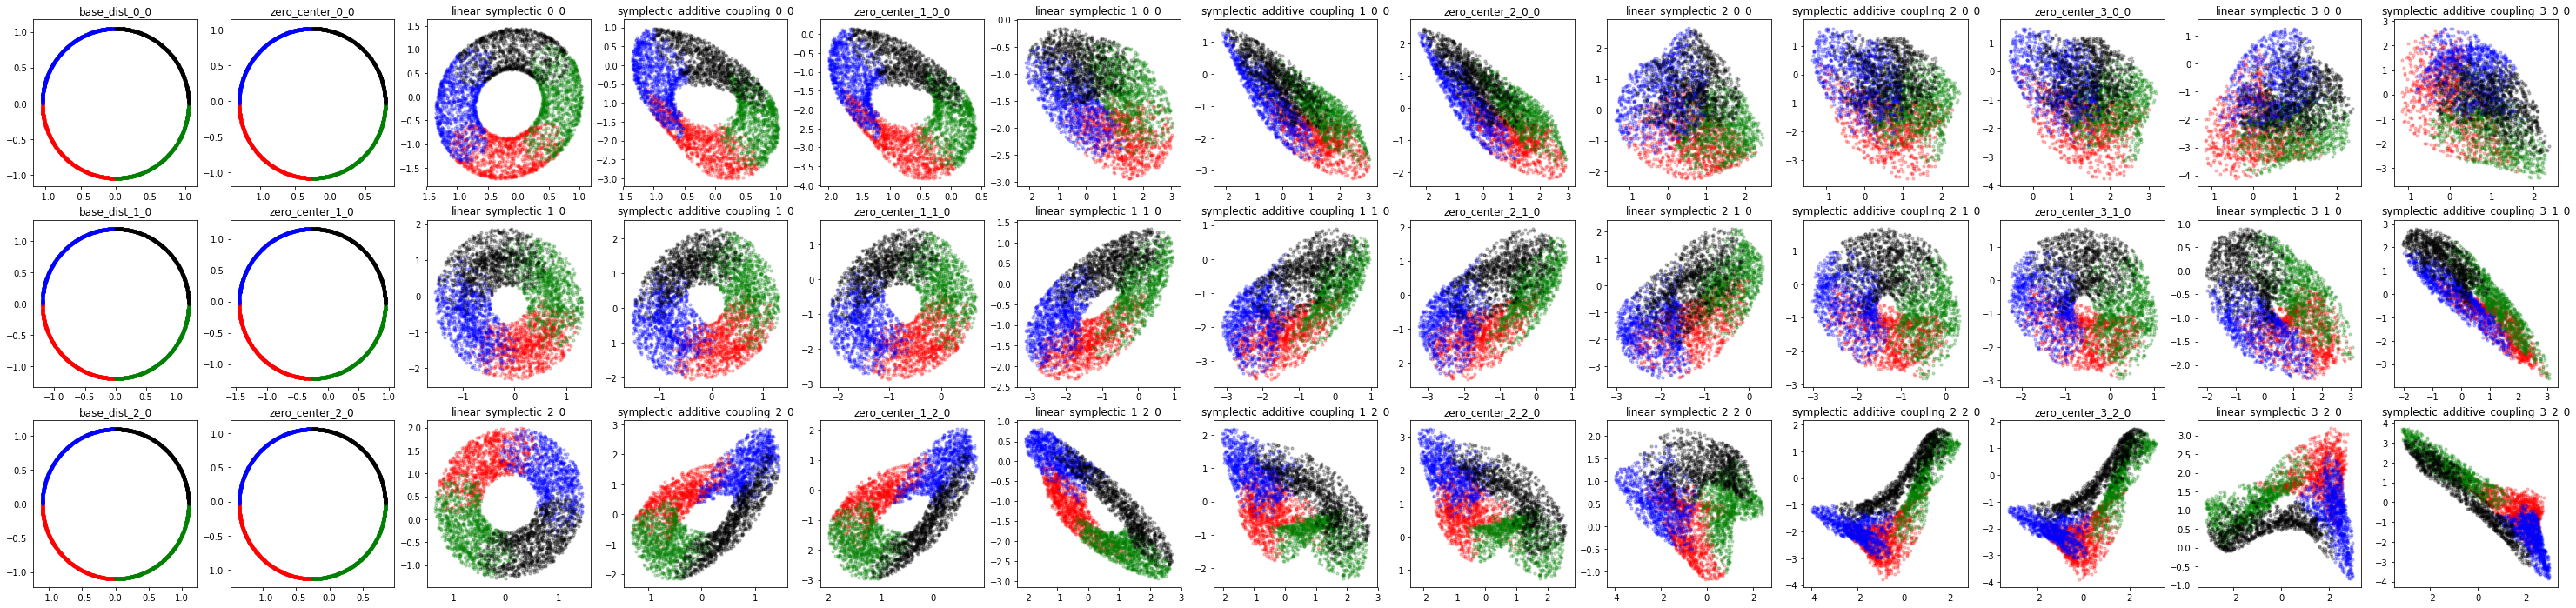

In [74]:
visualize_chain_bijector(T, tf.constant(circles_np,dtype=DTYPE), sess=sess, inverse=False)

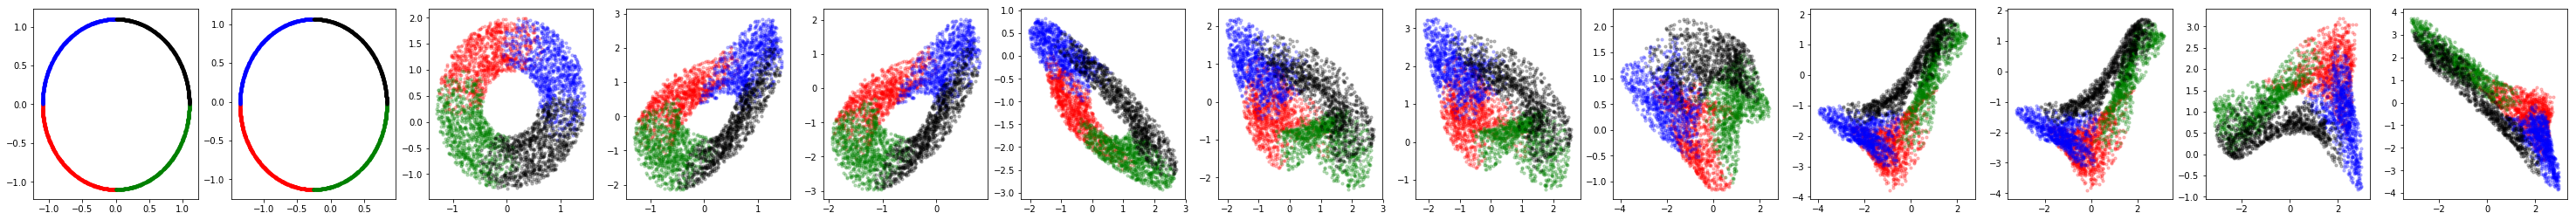

In [94]:
visualize_chain_bijector_one_coord(T, tf.constant(circles_np,dtype=DTYPE), sess=sess, inverse=False)

In [93]:
def visualize_chain_bijector_one_coord(model, x, sess=None, inverse=False):
    # Compute data
    samples = [sess.run(x)]
    names = ["base_dist"]
    if inverse:
        for bijector in reversed(model.bijectors):
            x = bijector.inverse(x)
            samples.append(sess.run(x))
            names.append(bijector.name)
    else:
        for bijector in model.bijectors:
            x = bijector(x)
            samples.append(sess.run(x))
            names.append(bijector.name)

    d = samples[0].shape[1]
    num_particles = samples[0].shape[2]
    nrows = 1
    ncols = len(samples)
    f, arr = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
    
    a = 2 # d
    b = 0 # num_particles
    # X0 is the first column
    X0 = np.reshape(samples[0][:,a,b], (samples[0].shape[0], 2))
    # Go throught the columns
    for i in range(len(samples)):
        X1 = np.reshape(samples[i][:,a,b], (samples[i].shape[0], 2))

        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
        arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red',
                           alpha=.25)
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
        arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green',
                           alpha=.25)
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
        arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue',
                           alpha=.25)
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
        arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black',
                           alpha=.25)
#        arr[row,i].set_xlim([-10, 10])
#        arr[rowi].set_ylim([-10, 10])
        #arr[i].set_title(names[i]+"_"+str(a)+"_"+str(b))
    
    plt.savefig('../results/viz_neumann.png')

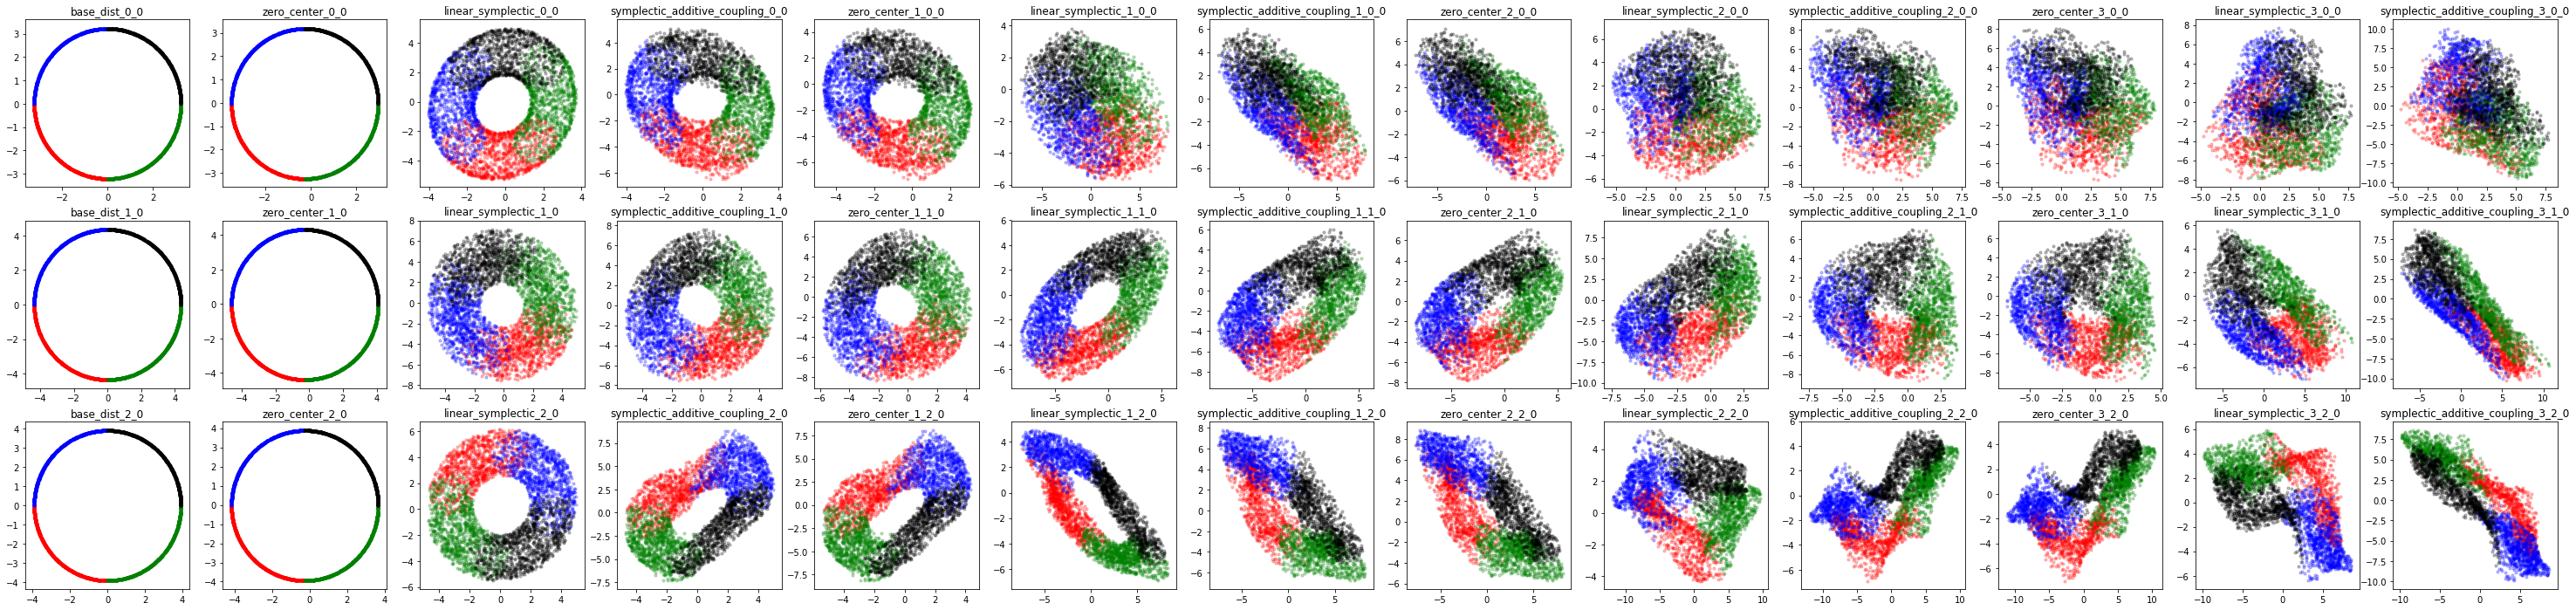

In [70]:
visualize_chain_bijector(T, tf.constant(circles_np,dtype=DTYPE), sess=sess, inverse=False)